In [1]:
samples = []

with open('Data/oznaczenia.txt') as fp:
    for line in fp.readlines():
        [filename, end, start] = line[:-1].split("\t")
        samples.append((filename, int(start), int(end)))

samples

[('0001_1_.nii.gz', 105, 137),
 ('0001_2_.nii.gz', 100, 132),
 ('0002_1_.nii.gz', 93, 130),
 ('0002_2_.nii.gz', 87, 123),
 ('0003_1_.nii.gz', 100, 131),
 ('0003_2_.nii.gz', 101, 133),
 ('0004_1_.nii.gz', 169, 200),
 ('0004_2_.nii.gz', 162, 191),
 ('0005_1_.nii.gz', 120, 151),
 ('0006_1_.nii.gz', 183, 214),
 ('0006_2_.nii.gz', 179, 212),
 ('0007_1_.nii.gz', 189, 222),
 ('0007_2_.nii.gz', 108, 145),
 ('0008_1_.nii.gz', 186, 216),
 ('0008_2_.nii.gz', 169, 199),
 ('0009_1_.nii.gz', 183, 219),
 ('0009_2_.nii.gz', 173, 212),
 ('0010_1_.nii.gz', 168, 197),
 ('0010_2_.nii.gz', 104, 134)]

In [2]:
import torch
import nibabel as nib
import random

slices = []
targets = []

for filename, start, end in samples:
    img = nib.load(f"Data/{filename}").get_fdata()
    # Positive slices
    for depth in range(start, end + 1):
        s = img[:, :, depth]
        slices.append(torch.tensor(s, dtype=torch.float).unsqueeze(0))
        targets.append(1)
    negative_indices = list(range(0, start)) + list(range(end, img.shape[2]))
    chosen_negative_indices = random.sample(negative_indices, end - start + 1)
    for depth in chosen_negative_indices:
        s = img[:, :, depth]
        slices.append(torch.tensor(s, dtype=torch.float).unsqueeze(0))
        targets.append(0)
    

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(slices, targets, test_size=0.2)
print(len(X_train))
print(f"{sum(y_train)}/{len(y_train)}")
print(f"{sum(y_test)}/{len(y_test)}")
print(len(X_test))

1020
512/1020
126/256
256


In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from typing import List
from sklearn.model_selection import train_test_split
import torch.nn.functional as F


class SlicesDataset:
    def __init__(self, slices: torch.tensor, targets: List[bool], transform = None):
        self.slices = slices
        self.targets = torch.tensor(targets, dtype=torch.int64)

    def __getitem__(self, idx):
        s = transform(self.slices[idx]) if transform is not None else self.slices[idx]
        target = F.one_hot(self.targets[idx], 2).float()
        return s, target
        
    def __len__(self):
        return len(self.targets)


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Normalize(mean=[0.485], std=[0.229]),
])

train_dataset = SlicesDataset(X_train, y_train, transform)
test_dataset = SlicesDataset(X_test, y_test, transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

tensor([1., 0.])


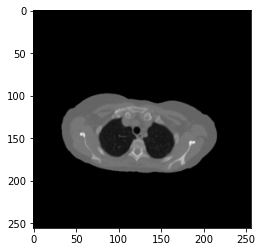

In [5]:
import matplotlib.pyplot as plt

s, target = next(iter(train_loader))

print(target[0])
plt.gray()
plt.imshow(s[0][0])

In [6]:
from torchvision.models import densenet121
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = densenet121(num_classes=2)
model.features[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model = model.to(device)

In [7]:
from tqdm import tqdm

def train(model, train_loader, optimizer, criterion, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc="Training Epoch"):
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track the loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        _, true_predictions = torch.max(labels, 1)
        correct += (predicted == true_predictions).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total * 100
    return epoch_loss, epoch_accuracy

# Testing loop
def test(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # No gradient computation during testing
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track the loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            _, true_predictions = torch.max(labels, 1)
            correct += (predicted == true_predictions).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / len(test_loader)
    epoch_accuracy = correct / total * 100
    return epoch_loss, epoch_accuracy


def train_loop(model, train_loader, test_loader, criterion, optimizer, device, num_epochs):
    for epoch in range(num_epochs):
        # Training
        train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    
        # Testing
        test_loss, test_accuracy = test(model, test_loader, criterion, device)
        print(f"Epoch {epoch+1}/{num_epochs} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

train_loop(model, train_loader, test_loader, criterion, optimizer, device, 5)

Training Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:15<00:00,  4.16it/s]


Epoch 1/5 - Train Loss: 0.2765, Train Accuracy: 88.33%


Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.73it/s]


Epoch 1/5 - Test Loss: 1.6518, Test Accuracy: 55.47%


Training Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:14<00:00,  4.34it/s]


Epoch 2/5 - Train Loss: 0.1747, Train Accuracy: 94.22%


Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.53it/s]


Epoch 2/5 - Test Loss: 0.1000, Test Accuracy: 97.27%


Training Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:14<00:00,  4.34it/s]


Epoch 3/5 - Train Loss: 0.1579, Train Accuracy: 95.20%


Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.65it/s]


Epoch 3/5 - Test Loss: 0.2027, Test Accuracy: 94.14%


Training Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:14<00:00,  4.33it/s]


Epoch 4/5 - Train Loss: 0.1573, Train Accuracy: 93.82%


Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.54it/s]


Epoch 4/5 - Test Loss: 0.2384, Test Accuracy: 89.84%


Training Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:14<00:00,  4.33it/s]


Epoch 5/5 - Train Loss: 0.1236, Train Accuracy: 95.49%


Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.57it/s]

Epoch 5/5 - Test Loss: 0.0751, Test Accuracy: 96.88%
